# 1. Load Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

# this is pandas table width setting
pd.set_option('display.max_columns', None) 

C:\Users\ericx\AppData\Local\conda\conda\envs\PY35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 2. Load Data

In [2]:
# load train1, test1, rul1 pickle to have a test

train = pd.read_pickle('data/train.pkl')
test = pd.read_pickle('data/test.pkl')

# prepare feature list to each model

feature_s = ['cycle_norm','setting1','setting2','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
feature = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
feature_ts = ['cycle_norm','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [35]:
# test data and train data are all defined as cycle = 15 then w1 = 1

0    13036
1       60
Name: w1, dtype: int64


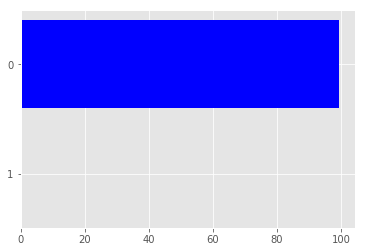

In [36]:
print(test['w1'].value_counts())
tmp = (test['w1'].value_counts() / test.shape[0]).sort_values(ascending = True) * 100
plt.barh(range(2), tmp, align = 'center', color = 'blue')
plt.yticks(range(2), tmp.index)
plt.show()

0    19031
1     1600
Name: w1, dtype: int64


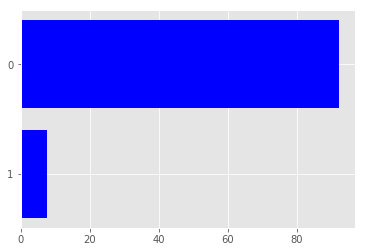

In [37]:
print(train['w1'].value_counts())
tmp = (train['w1'].value_counts() / train.shape[0]).sort_values(ascending = True) * 100
plt.barh(range(2), tmp, align = 'center', color = 'blue')
plt.yticks(range(2), tmp.index)
plt.show()

### Training Data for Time Series

In [116]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

sequence_length = 50
seq_gen = (list(gen_sequence(train[train['id']==id], sequence_length, feature_s)) for id in train['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print('seq_array shape: ',seq_array.shape)

seq_array shape:  (15631, 50, 17)


# 3. Regression LSTM

### Training Label for Time Series

In [117]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train[train['id']==id], sequence_length, ['rul']) for id in train['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
print('label_array shape: ', label_array.shape)

label_array shape:  (15631, 1)


### Model

In [142]:
# define path to save model
model_path = 'regression_model.h5'           
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input/output size
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# modeling
model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
print(model.summary())

# fitting
history = model.fit(seq_array, label_array, epochs=100, batch_size=250, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 50, 100)           47200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
Total params: 77,451
Trainable params: 77,451
Non-trainable params: 0
_________________________________________________________________
None
T

Epoch 42/100
 - 23s - loss: 990.0174 - mean_absolute_error: 19.5593 - r2_keras: 0.6977 - val_loss: 867.0238 - val_mean_absolute_error: 18.7088 - val_r2_keras: 0.7060
Epoch 43/100
 - 24s - loss: 969.8775 - mean_absolute_error: 19.4142 - r2_keras: 0.7039 - val_loss: 924.0018 - val_mean_absolute_error: 18.8953 - val_r2_keras: 0.7028
Epoch 44/100
 - 23s - loss: 934.6582 - mean_absolute_error: 19.0223 - r2_keras: 0.7142 - val_loss: 855.9780 - val_mean_absolute_error: 19.6254 - val_r2_keras: 0.6710
Epoch 45/100
 - 24s - loss: 909.9654 - mean_absolute_error: 18.8153 - r2_keras: 0.7218 - val_loss: 819.7569 - val_mean_absolute_error: 19.0516 - val_r2_keras: 0.6724
Epoch 46/100
 - 24s - loss: 867.1851 - mean_absolute_error: 18.4087 - r2_keras: 0.7352 - val_loss: 1053.7858 - val_mean_absolute_error: 18.5979 - val_r2_keras: 0.7085
Epoch 47/100
 - 24s - loss: 837.1513 - mean_absolute_error: 18.0089 - r2_keras: 0.7444 - val_loss: 830.4473 - val_mean_absolute_error: 18.7659 - val_r2_keras: 0.6397
Epo

### Check Overfitting

In [143]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'test'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ericx\\AppData\\Local\\conda\\conda\\envs\\PY35\\lib\\site-packages\\matplotlib\\pyplot.py'>

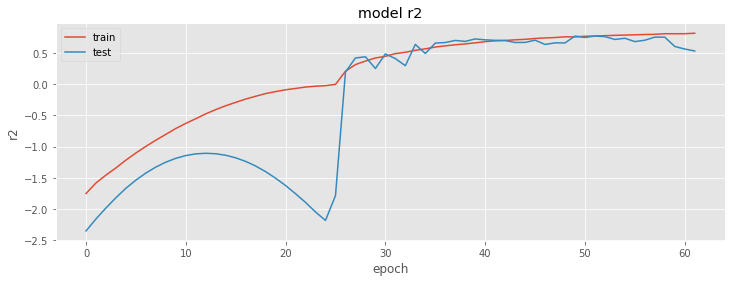

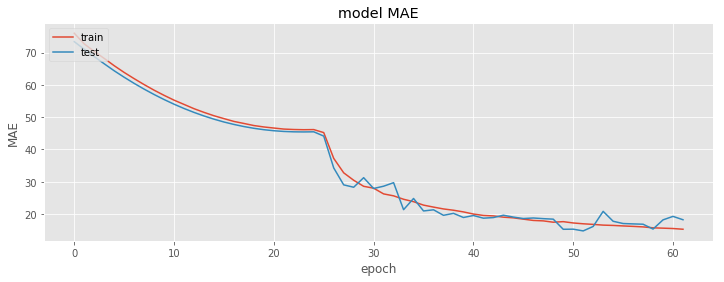

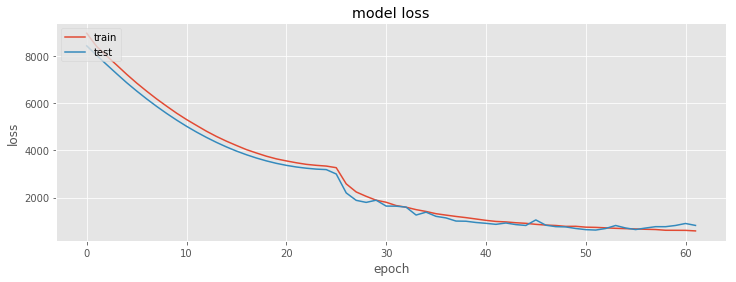

In [144]:
history_plot('r2_keras', 'val_r2_keras', 'model r2', 'r2', 'epoch')
history_plot('mean_absolute_error', 'val_mean_absolute_error', 'model MAE', 'MAE', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

### Performance

In [146]:
scores = model.evaluate(seq_array, label_array, batch_size=250, verbose=2)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=2, batch_size=250)
y_true = label_array
test_set = pd.DataFrame(y_pred)


MAE: 13.877024712256587

R^2: 0.8054496281344223


### Validation


MAE: 12.015435106010846

R^2: 0.7943724207980658


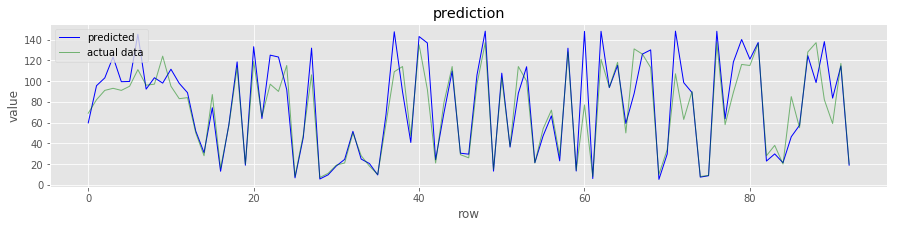

In [147]:
seq_array_test_last = [test[test['id']==id][feature_s].values[-sequence_length:] 
                       for id in test['id'].unique() if len(test[test['id']==id]) >= sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test[test['id']==id]) >= sequence_length for id in test['id'].unique()]
label_array_test_last = test.groupby('id')['rul'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path, custom_objects={'r2_keras': r2_keras})
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    test_set = pd.DataFrame(y_pred_test)

    fig_verify = plt.figure(figsize=(15, 3))
    plt.plot(y_pred_test, color="blue", linewidth=1, alpha=1)
    plt.plot(y_true_test, color="green", linewidth=1, alpha=0.5)
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.figure(dpi=1200)
    plt.show()

# 4. Classification LSTM

### Training Label for Time Series

In [179]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train[train['id']==id], sequence_length, ['w1']) for id in train['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
print('label_array shape: ', label_array.shape)

label_array shape:  (15631, 1)


### Model

In [203]:
model_path_clf = 'classification_model.h5'  
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# fitting
history = model.fit(seq_array, label_array, epochs=50, batch_size=250, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 50, 100)           47200     
_________________________________________________________________
dropout_59 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_60 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 77,451
Trainable params: 77,451
Non-trainable params: 0
_________________________________________________________________
None
Train on 14849 samples, validate on 782 samples
Epoch 1/50
 - 44s - loss: 0.2407 - acc: 0.9178 - val_loss: 0.1550 - val_acc: 0.9373
E

### Check Overfitting

<module 'matplotlib.pyplot' from 'C:\\Users\\ericx\\AppData\\Local\\conda\\conda\\envs\\PY35\\lib\\site-packages\\matplotlib\\pyplot.py'>

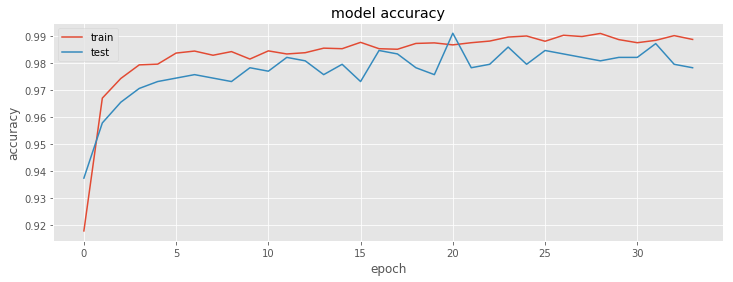

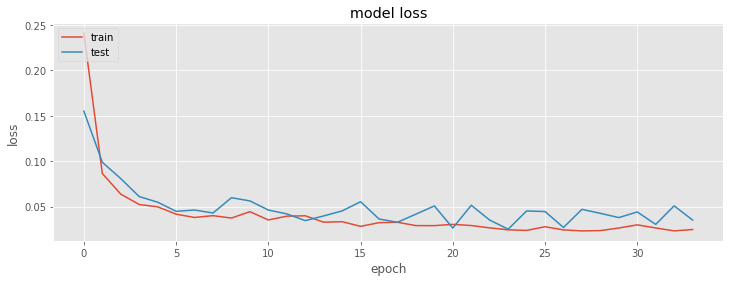

In [204]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

### Performance

In [205]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=250)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=250)
y_true = label_array

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

print('Confusion matrix ---------------------------\n x-axis is true, y-axis is predict')
print(confusion_matrix(y_true, y_pred))

15631/15631 [==============================] - 15s 944us/step
Accurracy: 0.9907875293909295
15631/15631 [==============================] - 18s 1ms/step
precision =  0.9401451027811366 
 recall =  0.971875
Confusion matrix ---------------------------
 x-axis is true, y-axis is predict
[[13932    99]
 [   45  1555]]


### Validation

Accurracy: 0.978494623655914
93/93 [==============================] - 3s 28ms/step
Confusion matrix ------------------------
 x-axis is true, y-axis is predict
[[82  1]
 [ 1  9]]
Precision:  0.9 
 Recall:  0.9 
 F1-score: 0.9


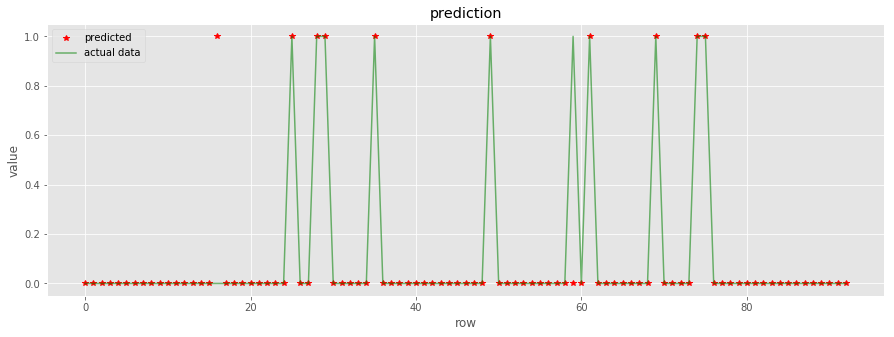

In [222]:
seq_array_test_last = [test[test['id']==id][feature_s].values[-sequence_length:] 
                       for id in test['id'].unique() if len(test[test['id']==id]) >= sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test[test['id']==id]) >= sequence_length for id in test['id'].unique()]
label_array_test_last = test.groupby('id')['w1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path_clf):
    estimator = load_model(model_path_clf)
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('Accurracy: {}'.format(scores_test[1]))
    y_pred_test = estimator.predict_classes(seq_array_test_last,verbose=1, batch_size=250)
    y_true_test = label_array_test_last
    test_set = pd.DataFrame(y_pred_test)
    
    # confusion matrix
    print('Confusion matrix ------------------------\n x-axis is true, y-axis is predict')
    print(confusion_matrix(y_true_test, y_pred_test))
    
    # precision and recall
    precision_test = precision_score(y_true_test, y_pred_test)
    recall_test = recall_score(y_true_test, y_pred_test)
    f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
    print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )
    
    fig_verify = plt.figure(figsize=(15, 5))
    plt.plot(y_pred_test, '*', color="red",  alpha=1)
    plt.plot(y_true_test, color="green",  alpha=0.55)
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.figure(dpi=1200)
    plt.show()